In [1]:
import os
import glob
import shutil

import cv2
import numpy as np  
import pandas as pd  
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mimg
import tensorflow as tf

# Import packages for data handling
import h5py
from PIL import Image
from skimage.io import imread
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from mlxtend.plotting import plot_confusion_matrix

# Import deep learning package (tensorflow)
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import mobilenet_v2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D
from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization, Concatenate
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

C:\Users\sriha\anaconda3\envs\JAN2022\lib\site-packages\skimage\io\manage_plugins.py:23: UserWarning: Your installed pillow version is < 8.1.2. Several security issues (CVE-2021-27921, CVE-2021-25290, CVE-2021-25291, CVE-2021-25293, and more) have been fixed in pillow 8.1.2 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


## Copy the images

## Explore Dataset

In [2]:
########################
# Set the data libraries
########################
path        = 'C:/Users/sriha/Desktop/antispoof/'
train_dir   = path + 'train'
test_dir    = path + 'test'
val_dir     = path + 'validation'
input_dir   = os.path.join(path)
dir_dict    = {'train': train_dir, 'val': val_dir, 'test': test_dir}

case_count, img_disp, set_length  = {}, {}, {}
os.chdir(path)
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

# Get the directory informations
label_name  = [subdir for subdir in sorted(os.listdir(train_dir)) if os.path.isdir(os.path.join(train_dir, subdir))]
dataset_dir = [dir for dir in sorted(os.listdir(input_dir)) if os.path.isdir(os.path.join(input_dir, dir))]

#########################
# Get the dataset summary
#########################
for key, val in dir_dict.items():
    case_count[key] = {}
    img_disp[key] = {}
    set_count = 0
    
    for label in label_name:
        label_list = list(sorted(glob.glob(os.path.join(val, label, "*.*"))))
        
        if len(label_list) == 0:
            continue

        case_count[key][label] = len(label_list)
        set_count += len(label_list)
        
        select_img_id = np.random.randint(len(label_list)-1)
        # print(select_img_id)
        img_disp[key][label] = label_list[select_img_id]
        
    set_length[key] = set_count

case_count_df = pd.DataFrame(case_count)
img_disp_df   = pd.DataFrame(img_disp)
print(f"Dataset summary:\n\n{case_count_df}\n")


Dataset summary:

       train  val  test
real    2353  530  1037
spoof   2369  522    71



## Visualize Dataset

In [3]:
def get_images(data_dir,number_of_samples):
    image_path = []
    for label in label_name:
        path = os.path.join(data_dir,label)
        i = 1
        for img in os.listdir(path):
            if i > number_of_samples:
                break
            else:
                image_path.append(os.path.join(path,img))
                i += 1
    return image_path

def visualize_dataset(image_path,rows,cols):
    fig = plt.figure(figsize=(20,20))
    for i in range(1,rows * cols + 1):
        fig.add_subplot(rows,cols,i)
        img_array = cv2.imread(image_path[i-1])
        fig.subplots_adjust(hspace=1)
        plt.imshow(cv2.cvtColor(img_array,cv2.COLOR_BGR2RGB))
        plt.xlabel(image_path[i-1].split('\\')[-2])
    plt.show()

#### Training Dataset

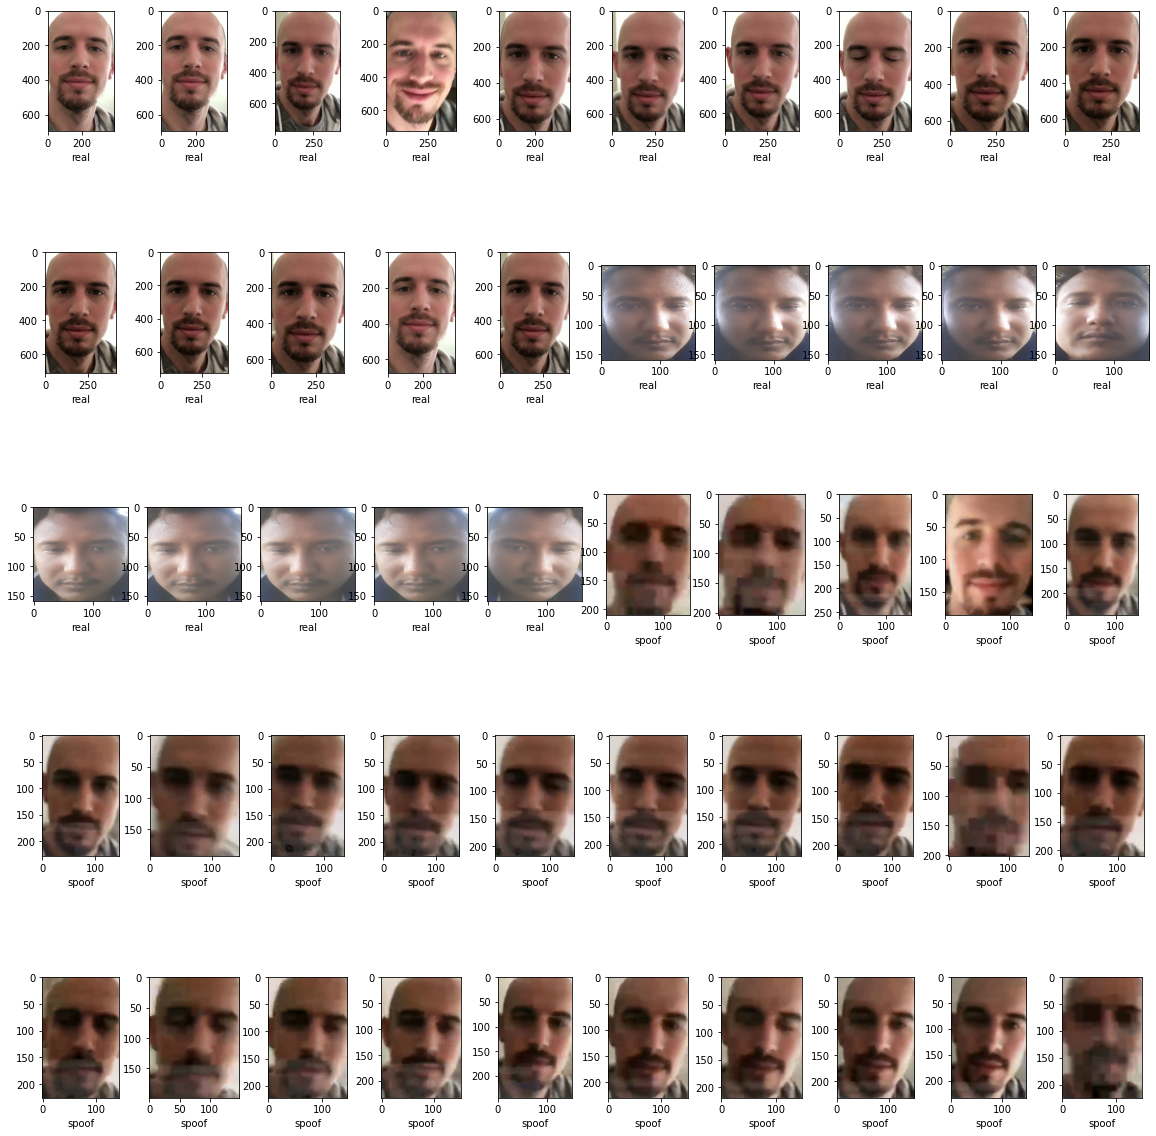

In [4]:
image_path = get_images(data_dir= train_dir,number_of_samples=25)
visualize_dataset(image_path,rows=5,cols=10)

#### Validation Dataset

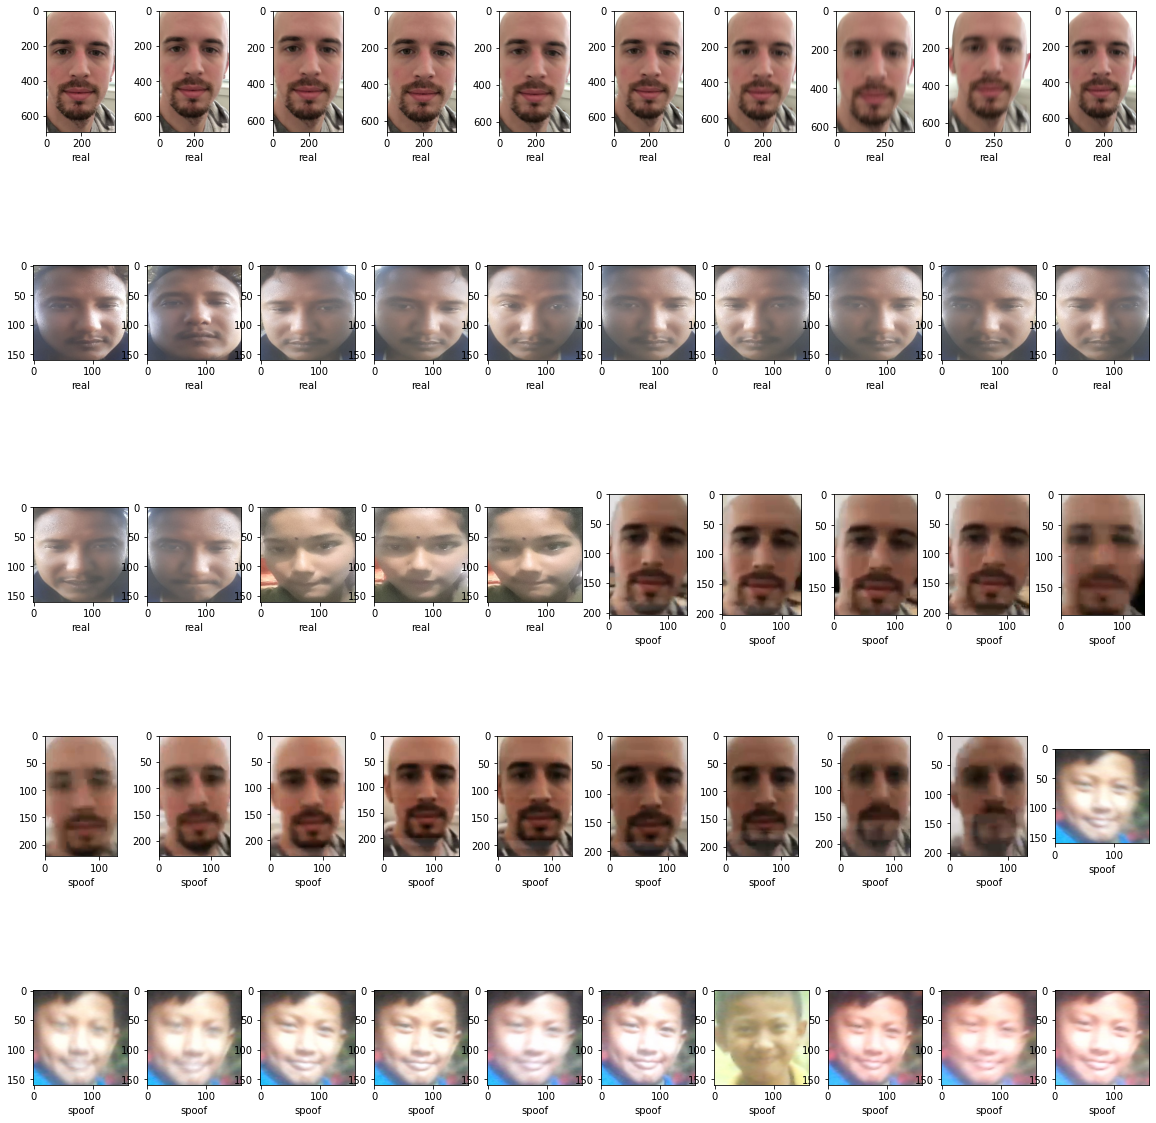

In [5]:
image_path = get_images(data_dir= val_dir,number_of_samples=25)
visualize_dataset(image_path,rows=5,cols=10)

## Model Preparation

In [7]:
########################################################################
# initialize the initial learning rate, batch size, and number of epochs
########################################################################
num_epochs    = 20   
learning_rate = 1e-5   

##################################
# Set seed nunmber to all packages
##################################
seed_number      = 24
train_batch_size = 32
img_width        = 224
img_height       = 224
np.random.seed(seed_number)
tf.random.set_seed(seed_number)

#########################################################################################
# preprocess train data by augmenting and rescaling pixel intensities to the range [0, 1]
# No augmentation for Test & validation images
#########################################################################################
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   brightness_range = (0.8,1.2),
                                   rotation_range = 30,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.15,
                                   zoom_range = 0.15,
                                   horizontal_flip = True,
                                   fill_mode="nearest")

val_datagen   = ImageDataGenerator(rescale = 1./255)
test_datagen  = ImageDataGenerator(rescale=1./255) 

##########################################
# Generate dataset for train, val and test
##########################################

train_gen = train_datagen.flow_from_directory(train_dir, batch_size = 32, class_mode = 'binary', color_mode = 'rgb',
                                              shuffle=True, target_size = (img_width, img_height), seed = seed_number)

val_gen = val_datagen.flow_from_directory(val_dir, batch_size = 32, class_mode = 'binary', color_mode = 'rgb',
                                          target_size = (img_width, img_height), seed = seed_number)

test_gen = test_datagen.flow_from_directory(test_dir, batch_size = 1, class_mode = 'binary', color_mode = 'rgb',
                                              target_size = (img_width, img_height), seed = seed_number, shuffle=False)

#####################
# Define class weight
#####################
train_length = len(train_gen.classes)
weight0 = train_length / case_count_df['train'][label_name[0]] * (1 / len(label_name))
weight1 = train_length / case_count_df['train'][label_name[1]] * (1 / len(label_name))
class_weight = {0: weight0, 1: weight1}

# learning rate scheduler with Plateau method
plateau_scheduler = ReduceLROnPlateau(factor=0.2, patience=3, verbose=1, min_delta= 0.005, min_lr=5e-7)

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', verbose=1, patience=5,mode='min', restore_best_weights=True)

#############
# Model Build
#############
pretrain_net  = mobilenet_v2.MobileNetV2(input_shape = (img_width, img_height, 3), include_top = False, weights = 'imagenet')

freeze_before = None  # use None to train, use "all" to freeze all the layers

if freeze_before:
    for layer in pretrain_net.layers:
        if layer.name == freeze_before:
            break
        else:
            layer.trainable = False
            
output     = pretrain_net.output
output     = Conv2D(32, (3, 3), activation='relu')(output)
output     = Dropout(rate=0.2, name='extra_dropout1')(output)
output     = GlobalAveragePooling2D()(output)
prediction = Dense(1, activation='sigmoid', name='classifier')(output)

model = Model(inputs=pretrain_net.input, outputs=prediction, name='mobilenetv2_spoof')
model.compile(optimizer = Adam(lr=learning_rate),loss = 'binary_crossentropy', metrics = ['acc'])

#################
# Train the model
#################
history = model.fit(train_gen, epochs = num_epochs, steps_per_epoch = set_length['train'] // train_batch_size,
                    validation_data = val_gen,  validation_steps = 1, callbacks = [plateau_scheduler,early_stopping])
                    #class_weight=class_weight)

################
# save the model
################
model.save(path+ 'antispoofMNet.h5')

Found 4722 images belonging to 2 classes.
Found 1052 images belonging to 2 classes.
Found 1108 images belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 147 steps, validate for 1 steps
Epoch 1/25
147/147 [==============================] - 608s 4s/step - loss: 0.2158 - acc: 0.9100 - val_loss: 2.6987 - val_acc: 0.4688
Epoch 2/25
147/147 [==============================] - 570s 4s/step - loss: 0.0514 - acc: 0.9823 - val_loss: 2.9669 - val_acc: 0.5312
Epoch 3/25
147/147 [==============================] - 680s 5s/step - loss: 0.0350 - acc: 0.9872 - val_loss: 1.8675 - val_acc: 0.5312
Epoch 4/25
147/147 [==============================] - 642s 4s/step - loss: 0.0208 - acc: 0.9942 - val_loss: 2.0977 - val_acc: 0.5938
Epoch 5/25
147/147 [==============================] - 590s 4s/step - loss: 0.0191 - acc: 0.9936 - val_loss: 1.2382 - val_acc: 0.7812
Epoch 6/25
147/147 [==============================] - 568s 4s/step - loss: 0.0136 - acc: 0.9951 - val_loss: 1.3653 - 

## Plot accuracy

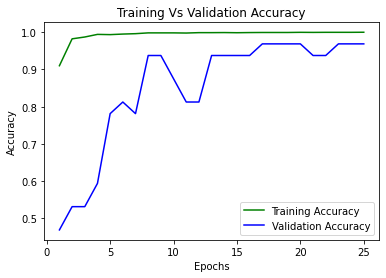

In [9]:
train_accuracy      = history.history['acc']
validation_accuracy = history.history['val_acc']
epochs = range(1,21)
plt.plot(epochs,train_accuracy,'g',label='Training Accuracy')
plt.plot(epochs,validation_accuracy,'b',label='Validation Accuracy')
plt.title('Training Vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Performance Evaluation

### Sample faces from the directory

  ...
    to  
  ['...']
Test results Accuracy: 99.55% and Loss: 99.55
1108/1108 [==============================] - 43s 38ms/step
[[1032    5]
 [   0   71]]


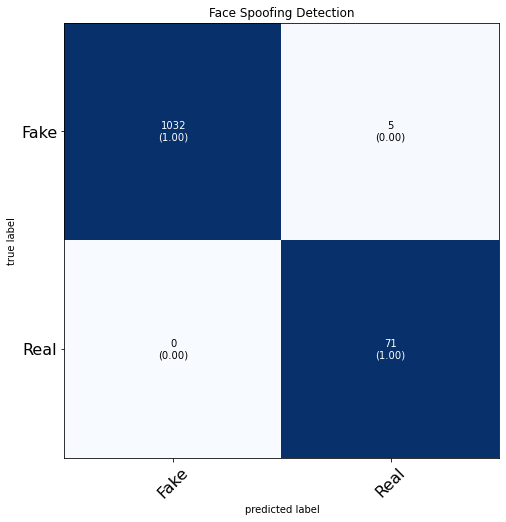

Report Summary:
Accuracy	: 99.55%
Precision	: 93.42%
Recall		: 100.00%
F1 Score	: 96.60%


In [10]:
################################
# Evaluate the model performance 
################################
model       = tf.keras.models.load_model(path+ 'antispoofMNet.h5')
test_scores = model.evaluate(test_gen, steps=set_length['test'],verbose=0)
print("Test results Accuracy: {0:.2f}% and Loss: {0:.2f}".format(test_scores[1]*100, test_scores[0]))

threshold    = 0.5   
y_pred_value = np.squeeze(model.predict(test_gen, steps=set_length['test'], verbose=1))

y_pred = np.zeros(y_pred_value.shape).astype(np.int32) 
y_pred[y_pred_value > threshold] = 1
y_pred = np.select([y_pred == 0, y_pred == 1], ['fake', 'real'], y_pred)

y_true = test_gen.classes
y_true = np.select([y_true == 0, y_true == 1], ['fake', 'real'], y_true)

########################
# Print confusion matrix
########################
confusion_matrix_result = confusion_matrix(y_true, y_pred)
print(confusion_matrix_result)

plot_confusion_matrix(confusion_matrix_result,
                      class_names = label_name,
                      figsize=(12,8),show_normed=True,
                      hide_ticks=True)

plt.title("Face Spoofing Detection")
plt.xticks(range(2), ['Fake', 'Real'], fontsize=16)
plt.yticks(range(2), ['Fake', 'Real'], fontsize=16)
plt.show()

#################
# Get the metrics
#################
tn, fp, fn, tp = confusion_matrix_result.ravel()
accuracy  = (tp+tn) /(tn+fp+fn+tp) 
precision = tp / (tp+fp)
recall = tp / (tp+fn)
f1_score = 2 * precision * recall / (precision+recall)

print("Report Summary:")
print("Accuracy\t: {:.2f}%".format(accuracy*100))
print("Precision\t: {:.2f}%".format(precision*100))
print("Recall\t\t: {:.2f}%".format(recall*100))
print("F1 Score\t: {:.2f}%".format(f1_score*100))

In [2]:
path        = 'C:/Users/sriha/Desktop/antispoof/'
model       = tf.keras.models.load_model(path+ 'antispoofMNet.h5')

### By capturing a Live pic

In [10]:
face_detector = cv2.CascadeClassifier('C:/Users/sriha/Documents/My_Data/Work_Documents/Posidex/face_rec/face_rec-blink/haarcascade_frontalface_default.xml')
os.environ['OPENCV_VIDEOIO_PRIORITY_MSMF'] = '0'
frame = []
#######################
# Capture face pictures
#######################

video = cv2.VideoCapture(0)  # 0 to specify to use built-in camera
count = 0

while True:
    ret, frame = video.read()
    frame      = cv2.resize(frame, (700, 600)) 
    faces      = face_detector.detectMultiScale(frame,scaleFactor=1.3,minNeighbors =5) 
    
    if faces is():       # No faces
        pass
    else:
        for(x,y,w,h) in faces: # Crop the faces found
            count+=1
            cv2.rectangle(frame, (x,y), (x+w,y+h), (255,0,0), 2)
            crop_face = frame[y:y+h, x:x+w]
            cv2.putText(crop_face, str(count),(50,50),cv2.FONT_HERSHEY_COMPLEX,1,(0,255,0),2)
            cv2.imshow('Face Photo',cv2.resize(frame,(900,700)))
            
        if cv2.waitKey(1)==13 or count==70: # 13 is ASCII code for Enter Key or Maximum of 75 images
            break

video.release()
cv2.destroyAllWindows()


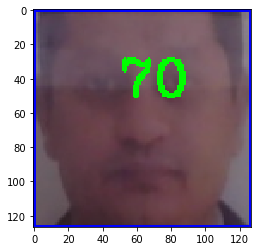

In [11]:
img  = cv2.cvtColor(crop_face,cv2.COLOR_BGR2RGB)
plt.imshow(img, interpolation='nearest')
plt.show()

In [12]:
test_img   = cv2.cvtColor(crop_face,cv2.COLOR_BGR2RGB)
test_img   = cv2.resize(test_img, (224, 224),interpolation = cv2.INTER_NEAREST)/255.0
test_img   = np.expand_dims(test_img.astype(np.float32), axis=0)
pred       = model.predict(test_img)
print(pred)
threshold    = 0.5   

if pred < threshold:
    print('The image is real')
else:
    print('The image is fake')

[[0.24339351]]
The image is real
